In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

%matplotlib inline

In [2]:
n_samples = 1500
random_state = 170

### Kmeans

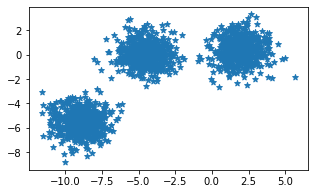

In [3]:
plt.figure(figsize=(5, 3))
X, y = datasets.make_blobs(n_samples=n_samples, centers=3, random_state=random_state)
plt.scatter(X[:,0], X[:,1], marker='*')

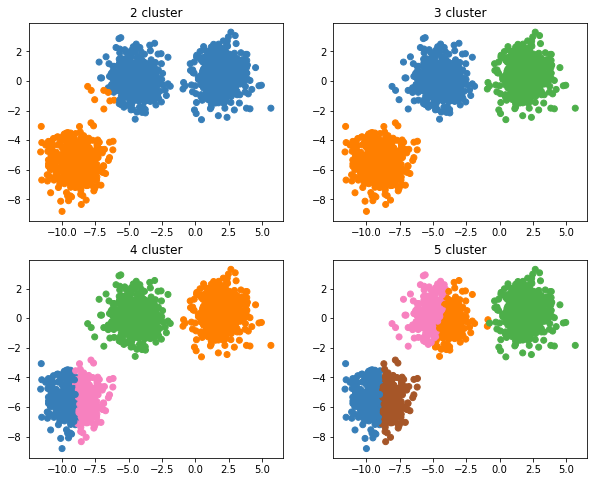

In [24]:
plt.figure(figsize = (10,8))

n_clusters = [2, 3, 4, 5]
for i, n in enumerate(n_clusters):
    plt.subplot(2, 2, i+1)
    y_pred = cluster.KMeans(n_clusters=n, random_state=random_state).fit_predict(X)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                      '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color = colors[y_pred])
    plt.title("{} cluster".format(n))

### Kmeans对数据分布的敏感度

Text(0.5, 1.0, 'Anisotropicly Distributed Blobs')

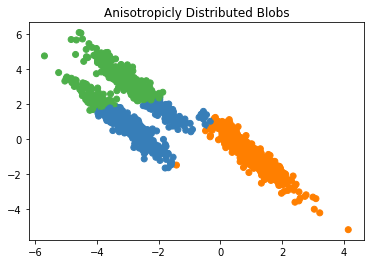

In [35]:
# 对数据进行一个转换，使得不再均匀分布， 有各向异性
# Kmeans的前提条件是cluster是圆形区域的
transformation = [[0.6, -0.636], [-0.40, 0.85]]
X_aniso = np.dot(X, transformation)

## 对X_aniso 做Kmeans，看看有什么结论
y_pred = cluster.KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                 '#f781bf', '#a65628', '#984ea3',
                                 '#999999', '#e41a1c', '#dede00']),
                          int(max(y_pred) + 1))))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], color=colors[y_pred])
plt.title("Anisotropicly Distributed Blobs")

### 环形分布的数据

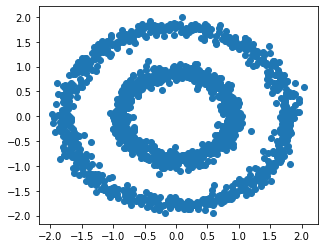

In [57]:
X, y = datasets.make_circles(n_samples = n_samples, factor = .5, noise = .05)
X = StandardScaler().fit_transform(X)
X.shape, y.shape

plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1])

In [62]:
# connectivity concept, kneighbors_graph
X_test = np.array([[0], [3], [1], [5]])
A = kneighbors_graph(X_test, n_neighbors=2, mode='connectivity', include_self = False)
print (A.toarray())

[[0. 1. 1. 0.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [0. 1. 1. 0.]]


### 定义不同clustering算法的训练以及可视化函数

In [63]:
def plot_cluster(X, y, params):

    # 利用kneighbors_graph， 建立 connectivity
    connectivity = kneighbors_graph(X, n_neighbors = params["n_neighbors"])
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # 定义kmeans，cluster数目根据传进来的参量
    kmeans = cluster.KMeans(n_clusters = params["n_clusters"])

    # 定义DBSCAN，eps和min_samples由传进来的params参量获得
    dbscan = cluster.DBSCAN(eps=params['eps'], min_samples = params["min_samples"])

    # 根据eulidean距离的average还是maximum得到 AgglomerativeClustering算法的两种average和complete linkage
    average_linkage = cluster.AgglomerativeClustering(linkage = "average",
                                                      affinity = "euclidean",
                                                      n_clusters = params['n_clusters'],
                                                      connectivity = connectivity)

    complete_linkage = cluster.AgglomerativeClustering(linkage = "complete",
                                                       affinity = "euclidean",
                                                       n_clusters = params['n_clusters'],
                                                       connectivity = connectivity)
    # GMM算法
    gmm = mixture.GaussianMixture(n_components = params['n_clusters'])

    # Spectral clustering的算法
    spectral = cluster.SpectralClustering(n_clusters = params['n_clusters'], 
                                          affinity = "nearest_neighbors")

    clustering_algorithms = (
        ('Kmeans', kmeans),
        ('DBSCAN', dbscan),
        ('Average linkage agglomerative clustering', average_linkage),
        ('Complete linkage agglomerative clustering', complete_linkage),
        ('Spectral clustering', spectral),
        ('GaussianMixture', gmm)
    )


    plt.figure(figsize = (10, 10))

    for i, (alg_name, algorithm) in enumerate(clustering_algorithms):
            t0 = time.time()
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)  # GMM

            plt.subplot(3, 2, i + 1)        
            colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
            plt.scatter(X[:, 0], X[:, 1], s = 10, color=colors[y_pred])

            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plt.title(alg_name)
            plt.text(.99, .01, ('time = %.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
    plt.show()

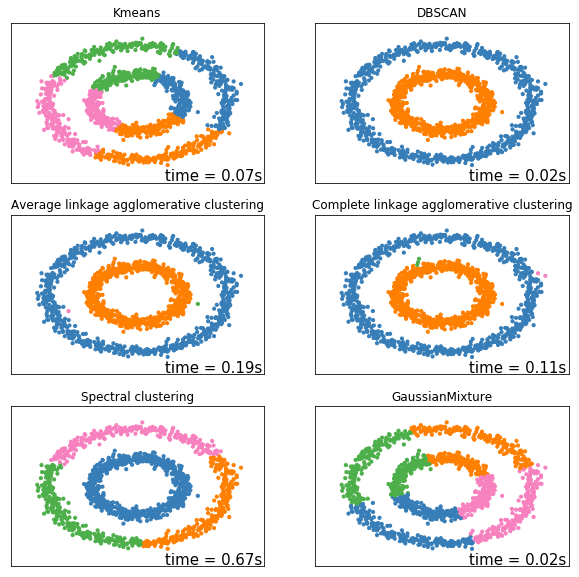

In [64]:
params = {'eps': .3, 'n_clusters': 4, "n_neighbors": 10, "min_samples": 10}
plot_cluster(X, y, params = params)

### moon shape

X shape: (1500, 2)
y shape: (1500,)


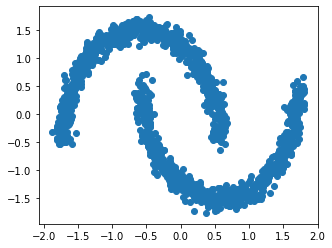

In [65]:
X, y = datasets.make_moons(n_samples = n_samples, noise = .05)
X = StandardScaler().fit_transform(X)
print ("X shape: " + str(X.shape))
print ("y shape: " + str( y.shape))

plt.figure(figsize = (5, 4))
plt.scatter(X[:,0], X[:,1])
plt.show()

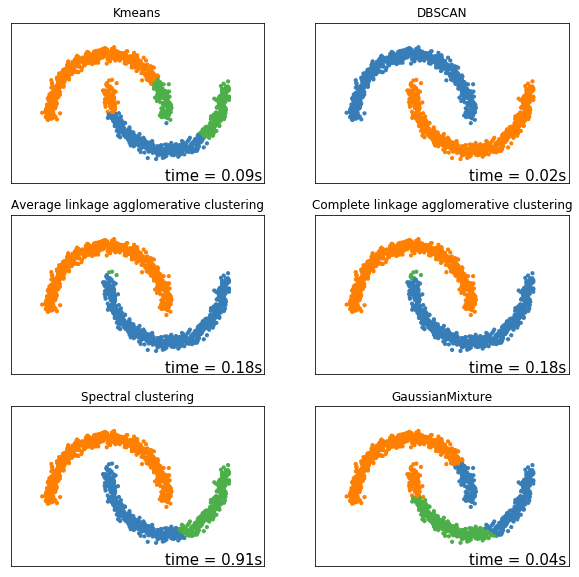

In [66]:
params = {'eps': .3, 'n_clusters': 3, "n_neighbors": 20, "min_samples": 10}
plot_cluster(X, y, params = params)

### blobs

X shape: (1500, 2)
y shape: (1500,)


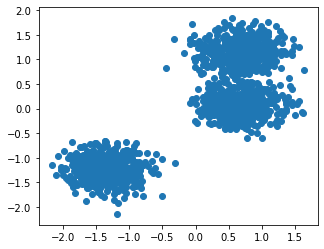

In [67]:
X, y = datasets.make_blobs(n_samples = n_samples, centers = 3, cluster_std = 2.0, random_state=8)
X = StandardScaler().fit_transform(X)
print ("X shape: " + str(X.shape))
print ("y shape: " + str( y.shape))

plt.figure(figsize = (5, 4))
plt.scatter(X[:,0], X[:,1])
plt.show()

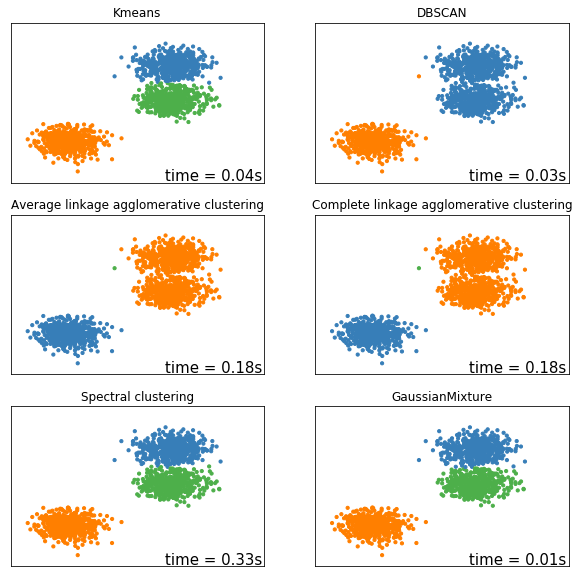

In [68]:
params = {'eps': .4, 'n_clusters': 3, "n_neighbors": 20, "min_samples": 10}
plot_cluster(X, y, params)

### blobs with varied variances

X shape: (1500, 2)
y shape: (1500,)


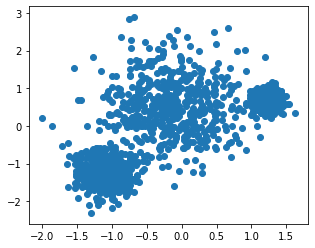

In [69]:
X, y = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

X = StandardScaler().fit_transform(X)
print ("X shape: " + str(X.shape))
print ("y shape: " + str( y.shape))

plt.figure(figsize = (5, 4))
plt.scatter(X[:,0], X[:,1])
plt.show()

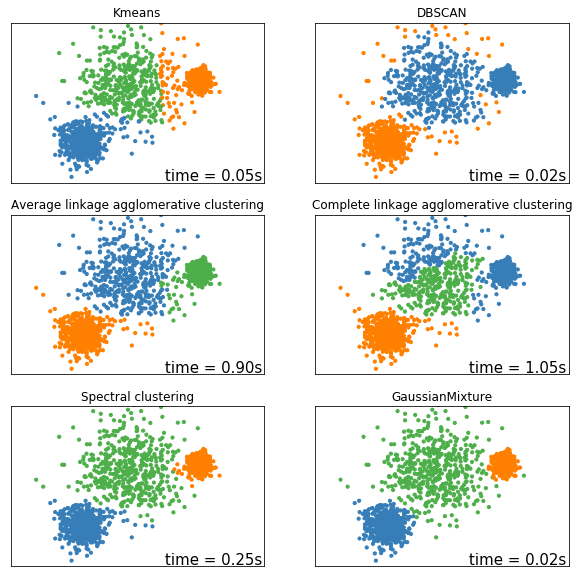

In [70]:
params = {'eps': 0.18, 'n_clusters': 3, "n_neighbors": 2, "min_samples" : 5}
plot_cluster(X, y, params = params)

### anisotropy

X shape: (1500, 2)
y shape: (1500,)


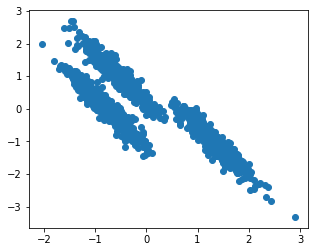

In [71]:
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)
X = StandardScaler().fit_transform(X)
print ("X shape: " + str(X.shape))
print ("y shape: " + str( y.shape))

plt.figure(figsize = (5, 4))
plt.scatter(X[:,0], X[:,1]
           )
plt.show()

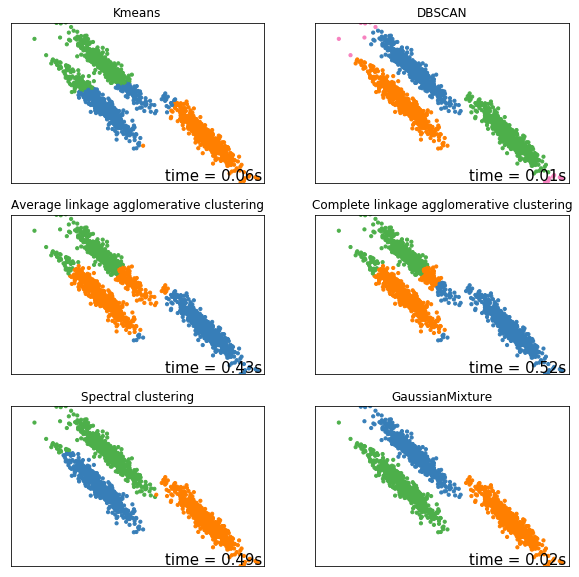

In [72]:
params = {'eps': 0.18, 'n_clusters': 3, "n_neighbors": 2, "min_samples" : 5}
plot_cluster(X, y, params = params)

### 随机样本

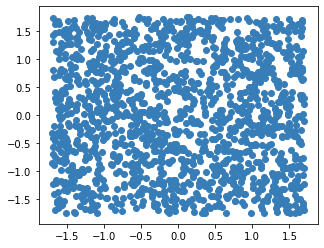

In [75]:
X, y = np.random.rand(n_samples, 2), None
X = StandardScaler().fit_transform(X)

plt.figure(figsize = (5, 4))
plt.scatter(X[:,0], X[:,1], color = '#377eb8')
plt.show()

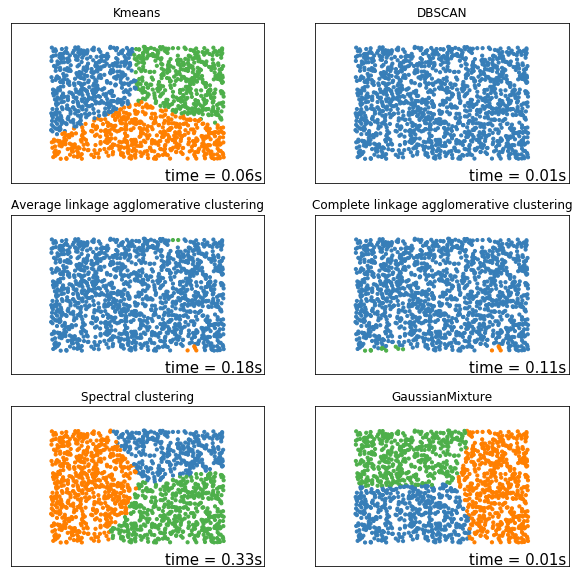

In [76]:
params = {'eps': 0.3, 'n_clusters': 3, "n_neighbors": 10, "min_samples" : 5}
plot_cluster(X, y, params = params)

### 层次聚类 dendrogram

In [77]:
from scipy.cluster import hierarchy

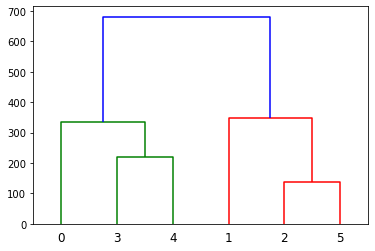

In [81]:
ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                  400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(ytdist, method = 'average', metric = "euclidean")
plt.figure()
dn = hierarchy.dendrogram(Z)